### **IMPORT**

In [ ]:
# Common imports
import numpy as np
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf


from sklearn.metrics import f1_score, recall_score, precision_score


from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.callbacks import Callback
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
from keras import backend as K


import copy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
import keras
import numpy as np
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers import SpatialDropout2D
from keras import regularizers
import matplotlib.pyplot as plt

### **DROPBLOCK FUNCTION**
## Building FPN as a custom layer and DropBlock
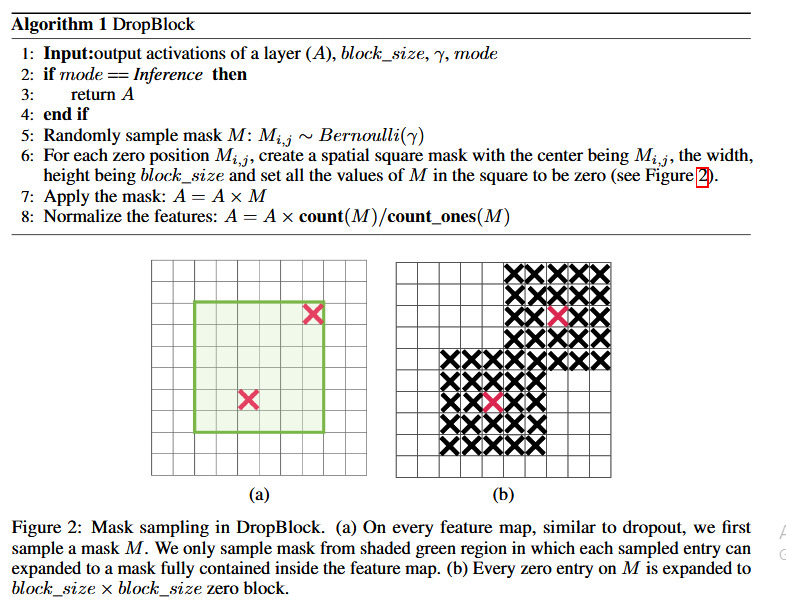


In [ ]:
from keras import backend as K


import copy

class NN_DropBlock(tf.keras.layers.Layer):

    def __init__(self, block_size, keep_prob, **kwargs):
        super(NN_DropBlock, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob

    def call(self, x, inference=None):

        # During inference, we do not Drop Blocks
        if inference == None:
            return x

        #padding
        z = self.block_size//2

        # Calculate Gamma
        feature_size = int(x.shape[-1])
        gamma = ((1-self.keep_prob)/(self.block_size**2)) * ((feature_size**2) / ((feature_size-self.block_size+1)**2))

        # Randomly sample mask
        sample_mask = tf.nn.relu(tf.sign(gamma - tf.random_uniform((feature_size-(z*2), feature_size-(z*2)), minval=0, maxval=1, dtype=tf.float32)))

        # The above code creates a matrix of zeros and samples ones from the distribution
        # We would like to flip all of these values
        sample_mask = 1-sample_mask

        # Pad the mask with ones
        sample_mask = np.pad(sample_mask, pad_width=z, mode='constant', constant_values=1)

        # For each 0, create spatial square mask of shape (block_size x block_size)
        spatial_square_mask = copy.copy(sample_mask)
        for i in range(feature_size):
            for j in range(feature_size):
                if sample_mask[i, j]==0:
                    spatial_square_mask[i-z : i+z+1, j-z : j+z+1] = 0

        spatial_square_mask = spatial_square_mask.reshape((1, feature_size, feature_size))

        # Apply the mask
        x = x * np.repeat(spatial_square_mask, x.shape[1], 0)

        # Normalize the features
        count = np.prod(spatial_square_mask.shape)
        count_ones = np.count_nonzero(spatial_square_mask == 1)
        x = x * count / count_ones

        return x

    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob
                  }
        base_config = super(NN_DropBlock, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


### **CALLBACK FUNCTION**

In [ ]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch,logs={}):
        for i in range(118):
          s = str(i)
          # vary the rate wrt epochs. That's what you want
          self.model.get_layer(name = s).keep_prob -= 0.066666667
    

### **DENSENET STANDARD**

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)     0           conv2d_121[0][0]                 
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 8, 8, 64)     256         max_pooling2d_1[0][0]            
___________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1563/1563 [==============================] - 188s 97ms/step - loss: 1.7232 - accuracy: 0.3672 - val_loss: 1.5684 - val_accuracy: 0.4439
Epoch 2/10
1563/1563 [==============================] - 143s 91ms/step - loss: 1.2466 - accuracy: 0.5541 - val_loss: 1.3704 - val_accuracy: 0.5063
Epoch 3/10
1563/1563 [==============================] - 143s 91ms/step - loss: 1.0280 - accuracy: 0.6349 - val_loss: 1.5023 - val_accuracy: 0.5201
Epoch 4/10
1563/1563 [==============================] - 143s 91ms/step - loss: 0.8655 - accuracy: 0.6924 - val_loss: 1.0897 - val_accuracy: 0.6219
Epoch 5/10
1563/1563 [==============================] - 142s 91ms/step - loss: 0.7190 - accuracy: 0.7465 - val_loss: 1.3101 - val_accuracy: 0.5869
Epoch 6/10
1563/1563 [==============================] - 142s 91ms/step - loss: 0.6013 - accuracy: 0.7885 - val_loss: 1.1426 - val_accuracy: 0.6329
Epoch 7/10
1563/1563 [==============================] - 143s 91ms/step - loss: 0.4973 - accuracy: 0.8260 - val_loss: 1

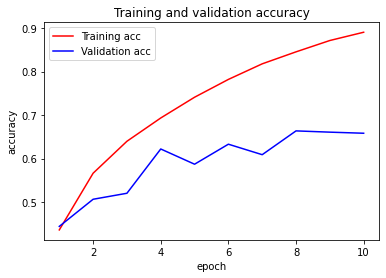

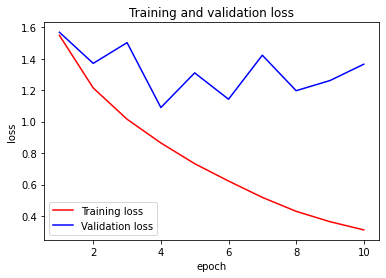

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np



def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16

  def bn_rl_conv( x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model




batch_size = 32
epochs = 10
num_classes = 10
# 3. LOADING TRAINING AND TEST SETS

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data splitting into training and test sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples') # number of samples in the training set
print(x_test.shape[0], 'test samples')
input_shape=x_train.shape[1:]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # y=2 ---> (0,0,1,0,0,...)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = densenet(input_shape, num_classes)
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True
              )

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

print(acc1)
print(val_acc1)
print(loss1)
print(val_loss1)

epochs = range(1, len(acc1) + 1)

plt.plot(epochs, acc1, 'r', label='Training acc')
plt.plot(epochs, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss1, 'r', label='Training loss')
plt.plot(epochs, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPOUT(0.25)**

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_493 (Conv2D)             (None, 16, 16, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 8, 8, 64)     0           conv2d_493[0][0]                 
__________________________________________________________________________________________________
batch_normalization_489 (BatchN (None, 8, 8, 64)     256         max_pooling2d_5[0][0]            
___________________

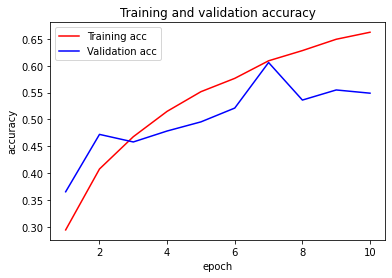

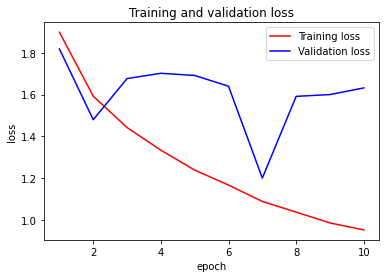

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np



def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16

  def bn_rl_conv( x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.25)(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model




batch_size = 32
epochs = 10
num_classes = 10
# 3. LOADING TRAINING AND TEST SETS

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data splitting into training and test sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples') # number of samples in the training set
print(x_test.shape[0], 'test samples')
input_shape=x_train.shape[1:]

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes) # y=2 ---> (0,0,1,0,0,...)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = densenet(input_shape, num_classes)
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True
              )

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

print(acc2)
print(val_acc2)
print(loss2)
print(val_loss2)

epochs = range(1, len(acc2) + 1)

plt.plot(epochs, acc2, 'r', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'r', label='Training loss')
plt.plot(epochs, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **SPATIAL(0.3)**

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)     0           conv2d_121[0][0]                 
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 8, 8, 64)     256         max_pooling2d_1[0][0]            
___________________

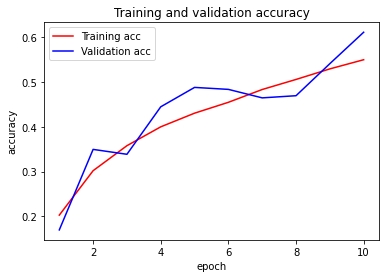

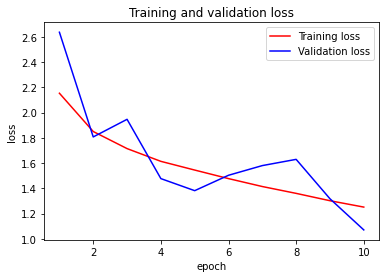

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np



def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16

  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = SpatialDropout2D(0.3)(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model




batch_size = 32
epochs = 10
num_classes = 10
# 3. LOADING TRAINING AND TEST SETS

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data splitting into training and test sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples') # number of samples in the training set
print(x_test.shape[0], 'test samples')
input_shape=x_train.shape[1:]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # y=2 ---> (0,0,1,0,0,...)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = densenet(input_shape, num_classes)
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True
              )

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc3 = history.history['accuracy']
val_acc3 = history.history['val_accuracy']
loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

print(acc3)
print(val_acc3)
print(loss3)
print(val_loss3)

epochs = range(1, len(acc3) + 1)

plt.plot(epochs, acc3, 'r', label='Training acc')
plt.plot(epochs, val_acc3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss3, 'r', label='Training loss')
plt.plot(epochs, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPBLOCK**

170508288/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8, 8, 64)     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return py_builtins.overload_of(f)(*args)


1563/1563 [==============================] - 395s 163ms/step - loss: 1.9218 - accuracy: 0.2877 - val_loss: 2.2544 - val_accuracy: 0.3044
Epoch 2/10
1563/1563 [==============================] - 243s 156ms/step - loss: 1.4748 - accuracy: 0.4615 - val_loss: 1.5379 - val_accuracy: 0.4834
Epoch 3/10
1563/1563 [==============================] - 242s 155ms/step - loss: 1.2767 - accuracy: 0.5362 - val_loss: 1.2018 - val_accuracy: 0.5834
Epoch 4/10
1563/1563 [==============================] - 242s 155ms/step - loss: 1.1255 - accuracy: 0.5968 - val_loss: 1.1131 - val_accuracy: 0.6148
Epoch 5/10
1563/1563 [==============================] - 241s 154ms/step - loss: 1.0176 - accuracy: 0.6383 - val_loss: 1.2565 - val_accuracy: 0.5789
Epoch 6/10
1563/1563 [==============================] - 241s 154ms/step - loss: 0.9219 - accuracy: 0.6748 - val_loss: 1.0383 - val_accuracy: 0.6538
Epoch 7/10
1563/1563 [==============================] - 240s 153ms/step - loss: 0.8497 - accuracy: 0.6972 - val_loss: 1.092

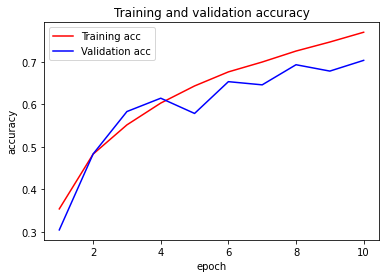

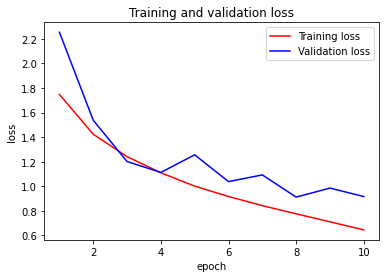

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np



def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  c = [0]

  def bn_rl_conv( c, x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = NN_DropBlock(block_size= 3, keep_prob = 0.9, name = str(c[0]))(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    c[0] = c[0]+1
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(c, tensor, 4*f)
      x = bn_rl_conv(c, x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(c, x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model




batch_size = 32
epochs = 10
num_classes = 10
# 3. LOADING TRAINING AND TEST SETS

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data splitting into training and test sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples') # number of samples in the training set
print(x_test.shape[0], 'test samples')
input_shape=x_train.shape[1:]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # y=2 ---> (0,0,1,0,0,...)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = densenet(input_shape, num_classes)
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = myCallback())

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc4 = history.history['accuracy']
val_acc4 = history.history['val_accuracy']
loss4 = history.history['loss']
val_loss4 = history.history['val_loss']

print(acc4)
print(val_acc4)
print(loss4)
print(val_loss4)

epochs = range(1, len(acc4) + 1)

print(epochs)

plt.plot(epochs, acc4, 'r', label='Training acc')
plt.plot(epochs, val_acc4, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss4, 'r', label='Training loss')
plt.plot(epochs, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPBLOCK 7**

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 8, 8, 64)     0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 8, 8, 64)     256         max_pooling2d[0][0]              
_____________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return py_builtins.overload_of(f)(*args)


1563/1563 [==============================] - 408s 169ms/step - loss: 1.8864 - accuracy: 0.3098 - val_loss: 1.5764 - val_accuracy: 0.4293
Epoch 2/10
1563/1563 [==============================] - 253s 162ms/step - loss: 1.4343 - accuracy: 0.4765 - val_loss: 1.3565 - val_accuracy: 0.5164
Epoch 3/10
1563/1563 [==============================] - 254s 162ms/step - loss: 1.2150 - accuracy: 0.5601 - val_loss: 1.2533 - val_accuracy: 0.5575
Epoch 4/10
1563/1563 [==============================] - 254s 162ms/step - loss: 1.0524 - accuracy: 0.6255 - val_loss: 1.0856 - val_accuracy: 0.6202
Epoch 5/10
1563/1563 [==============================] - 254s 163ms/step - loss: 0.9228 - accuracy: 0.6718 - val_loss: 0.9349 - val_accuracy: 0.6717
Epoch 6/10
1563/1563 [==============================] - 254s 162ms/step - loss: 0.8072 - accuracy: 0.7182 - val_loss: 0.9815 - val_accuracy: 0.6689
Epoch 7/10
1563/1563 [==============================] - 253s 162ms/step - loss: 0.6905 - accuracy: 0.7520 - val_loss: 1.076

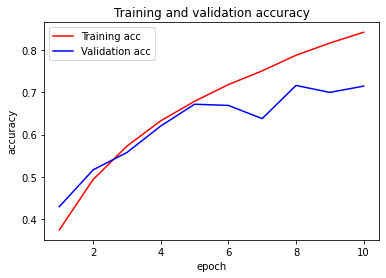

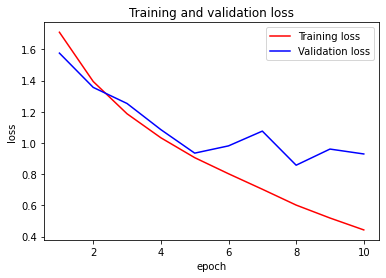

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np



def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  c = [0]

  def bn_rl_conv( c, x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = NN_DropBlock(block_size= 7, keep_prob = 0.9, name = str(c[0]))(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    c[0] = c[0]+1
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(c, tensor, 4*f)
      x = bn_rl_conv(c, x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(c, x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model




batch_size = 32
epochs = 10
num_classes = 10
# 3. LOADING TRAINING AND TEST SETS

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # data splitting into training and test sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples') # number of samples in the training set
print(x_test.shape[0], 'test samples')
input_shape=x_train.shape[1:]

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes) # y=2 ---> (0,0,1,0,0,...)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

model = densenet(input_shape, num_classes)
model.summary()

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr=0.0001, decay=1e-6),
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = myCallback())

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc5 = history.history['accuracy']
val_acc5 = history.history['val_accuracy']
loss5 = history.history['loss']
val_loss5 = history.history['val_loss']

print(acc5)
print(val_acc5)
print(loss5)
print(val_loss5)

epochs = range(1, len(acc5) + 1)

print(epochs)

plt.plot(epochs, acc5, 'r', label='Training acc')
plt.plot(epochs, val_acc5, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss5, 'r', label='Training loss')
plt.plot(epochs, val_loss5, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **MERGE RESULTS**

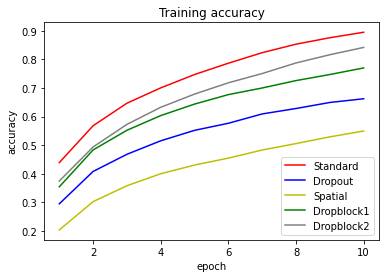

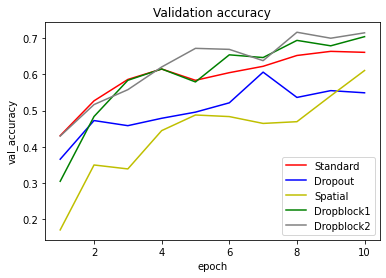

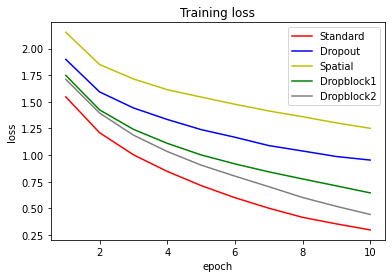

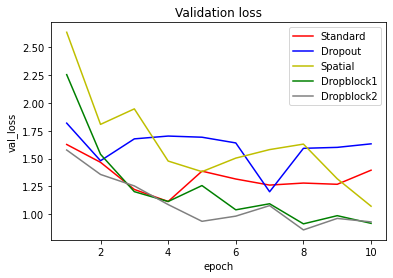

In [ ]:
acc1 = [0.43865999579429626, 0.5679000020027161, 0.6467199921607971, 0.7004600167274475, 0.7471200227737427, 0.7868199944496155, 0.823639988899231, 0.8534600138664246, 0.8759199976921082, 0.8952199816703796]
val_acc1 = [0.43050000071525574, 0.5267000198364258, 0.5857999920845032, 0.6146000027656555, 0.5834000110626221, 0.6044999957084656, 0.6220999956130981, 0.6520000100135803, 0.6633999943733215, 0.6607000231742859]
loss1 = [1.5461781024932861, 1.2094875574111938, 1.0027424097061157, 0.8466736674308777, 0.7139370441436768, 0.6000085473060608, 0.5015528202056885, 0.4156038761138916, 0.35402417182922363, 0.2973603308200836]
val_loss1 =[1.6262179613113403, 1.4657573699951172, 1.2215455770492554, 1.113080620765686, 1.3861030340194702, 1.3155156373977661, 1.260801076889038, 1.2790762186050415, 1.2680126428604126, 1.3948544263839722]

#Dropout
acc2 = [0.2943800091743469, 0.4077799916267395, 0.46786001324653625, 0.5151200294494629, 0.5516999959945679, 0.5764999985694885, 0.6091799736022949, 0.6281800270080566, 0.6492800116539001, 0.662339985370636]
val_acc2 =[0.3653999865055084, 0.4722000062465668, 0.45809999108314514, 0.47850000858306885, 0.49549999833106995, 0.5212000012397766, 0.6060000061988831, 0.5360999703407288, 0.5548999905586243, 0.5489000082015991]
loss2 = [1.8981106281280518, 1.5927964448928833, 1.442521572113037, 1.3342869281768799, 1.239100694656372, 1.1675416231155396, 1.08929443359375, 1.0383280515670776, 0.9865092039108276, 0.9531368613243103]
val_loss2 = [1.8182201385498047, 1.479971170425415, 1.6766412258148193, 1.7019330263137817, 1.6915252208709717, 1.6400810480117798, 1.2008205652236938, 1.5916001796722412, 1.6002024412155151, 1.6319422721862793]

#spatial
acc3 = [0.2030400037765503, 0.3020400106906891, 0.3577600121498108, 0.3997800052165985, 0.4302000105381012, 0.4544200003147125, 0.48291999101638794, 0.5053399801254272, 0.5288599729537964, 0.5492799878120422]
val_acc3 = [0.17010000348091125, 0.34950000047683716, 0.3386000096797943, 0.44440001249313354, 0.4875999987125397, 0.4832000136375427, 0.4643000066280365, 0.4690999984741211, 0.5404999852180481, 0.6104999780654907]
loss3 = [2.153040647506714, 1.8499767780303955, 1.7147153615951538, 1.613726258277893, 1.5448166131973267, 1.4771082401275635, 1.4143646955490112, 1.3602073192596436, 1.3020079135894775, 1.2516014575958252]
val_loss3 = [2.6359267234802246, 1.8070658445358276, 1.9465383291244507, 1.4770935773849487, 1.3816677331924438, 1.5035189390182495, 1.5801990032196045, 1.6295214891433716, 1.3175140619277954, 1.070885419845581]

#DropBlock
acc4 = [0.3539400100708008, 0.48306000232696533, 0.5519599914550781, 0.6033400297164917, 0.6437000036239624, 0.6768199801445007, 0.7000799775123596, 0.7259399890899658, 0.7472000122070312, 0.7702599763870239]
val_acc4 = [0.3043999969959259, 0.48339998722076416, 0.5834000110626221, 0.614799976348877, 0.5788999795913696, 0.6538000106811523, 0.6463000178337097, 0.6937000155448914, 0.6786999702453613, 0.7039999961853027]
loss4 = [1.7479100227355957, 1.4241012334823608, 1.2414286136627197, 1.1102927923202515, 1.0015791654586792, 0.917273998260498, 0.8426559567451477, 0.776054322719574, 0.7109652161598206, 0.6450068950653076]
val_loss4 = [2.2544350624084473, 1.5379284620285034, 1.2017509937286377, 1.1131250858306885, 1.2565494775772095, 1.0382922887802124, 1.0928229093551636, 0.9121366143226624, 0.9856657385826111, 0.9166726469993591]



#Dropblock 7 
acc5 = [0.3743000030517578, 0.49351999163627625, 0.5726199746131897, 0.6324999928474426, 0.678659975528717, 0.7181599736213684, 0.7506800293922424, 0.7876600027084351, 0.8165000081062317, 0.8420600295066833]
val_acc5 = [0.4293000102043152, 0.5163999795913696, 0.5575000047683716, 0.620199978351593, 0.6717000007629395, 0.6689000129699707, 0.6377000212669373, 0.7161999940872192, 0.6996999979019165, 0.7146000266075134]
loss5 = [1.710298776626587, 1.3941726684570312, 1.1873153448104858, 1.033356785774231, 0.9059514999389648, 0.8026831150054932, 0.7033554911613464, 0.601769208908081, 0.5188097953796387, 0.4424537122249603]
val_loss5 = [1.576408863067627, 1.3565260171890259, 1.2532767057418823, 1.085584282875061, 0.9349438548088074, 0.981480062007904, 1.0761224031448364, 0.8575319051742554, 0.9609882831573486, 0.929598331451416]




plt.plot(epochs, acc1, 'r', label='Standard')
plt.plot(epochs, acc2, 'b', label='Dropout')
plt.plot(epochs, acc3, 'y', label='Spatial')
plt.plot(epochs, acc4, 'g', label='Dropblock1')
plt.plot(epochs, acc5, 'grey', label='Dropblock2')
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, val_acc1, 'r', label='Standard')
plt.plot(epochs, val_acc2, 'b', label='Dropout')
plt.plot(epochs, val_acc3, 'y', label='Spatial')
plt.plot(epochs, val_acc4, 'g', label='Dropblock1')
plt.plot(epochs, val_acc5, 'grey', label='Dropblock2')
plt.title('Validation accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


plt.plot(epochs, loss1, 'r', label='Standard')
plt.plot(epochs, loss2, 'b', label='Dropout')
plt.plot(epochs, loss3, 'y', label='Spatial')
plt.plot(epochs, loss4, 'g', label='Dropblock1')
plt.plot(epochs, loss5, 'grey', label='Dropblock2')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, val_loss1, 'r', label='Standard')
plt.plot(epochs, val_loss2, 'b', label='Dropout')
plt.plot(epochs, val_loss3, 'y', label='Spatial')
plt.plot(epochs, val_loss4, 'g', label='Dropblock1')
plt.plot(epochs, val_loss5, 'grey', label='Dropblock2')
plt.title('Validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()